# Importation


In [ ]:
# Framework Poutyne
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-8do40v2u
  Running command git clone -q https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-8do40v2u
     |████████████████████████████████| 159 kB 5.3 MB/s 
  Created wheel for deeplib: filename=deeplib-0.1-py3-none-any.whl size=10532 sha256=a8c8641811545dad493ab70858cc634be7ac2ec2e6e1bc52b070e811e25b671a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ox9dbso/wheels/79/a1/51/69591e399f2c2709f89dc667613aa11a8467eea4864a056121
Successfully built deeplib


In [ ]:
#Dataset SOCOfing
! git clone https://github.com/angeliquebouchard/SOCOfing.git

Cloning into 'SOCOfing'...
remote: Enumerating objects: 55262, done.
remote: Counting objects: 100% (55262/55262), done.
remote: Compressing objects: 100% (52523/52523), done.
remote: Total 55262 (delta 2739), reused 55262 (delta 2739), pack-reused 0
Receiving objects: 100% (55262/55262), 402.27 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (2739/2739), done.
Checking out files: 100% (55270/55270), done.


# Import

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18,alexnet
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import time
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, ReduceLROnPlateau

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Chargement des données dans colab  (Decommenter toute les lignes et les executer)  
le tuto que j'ai suivi :
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

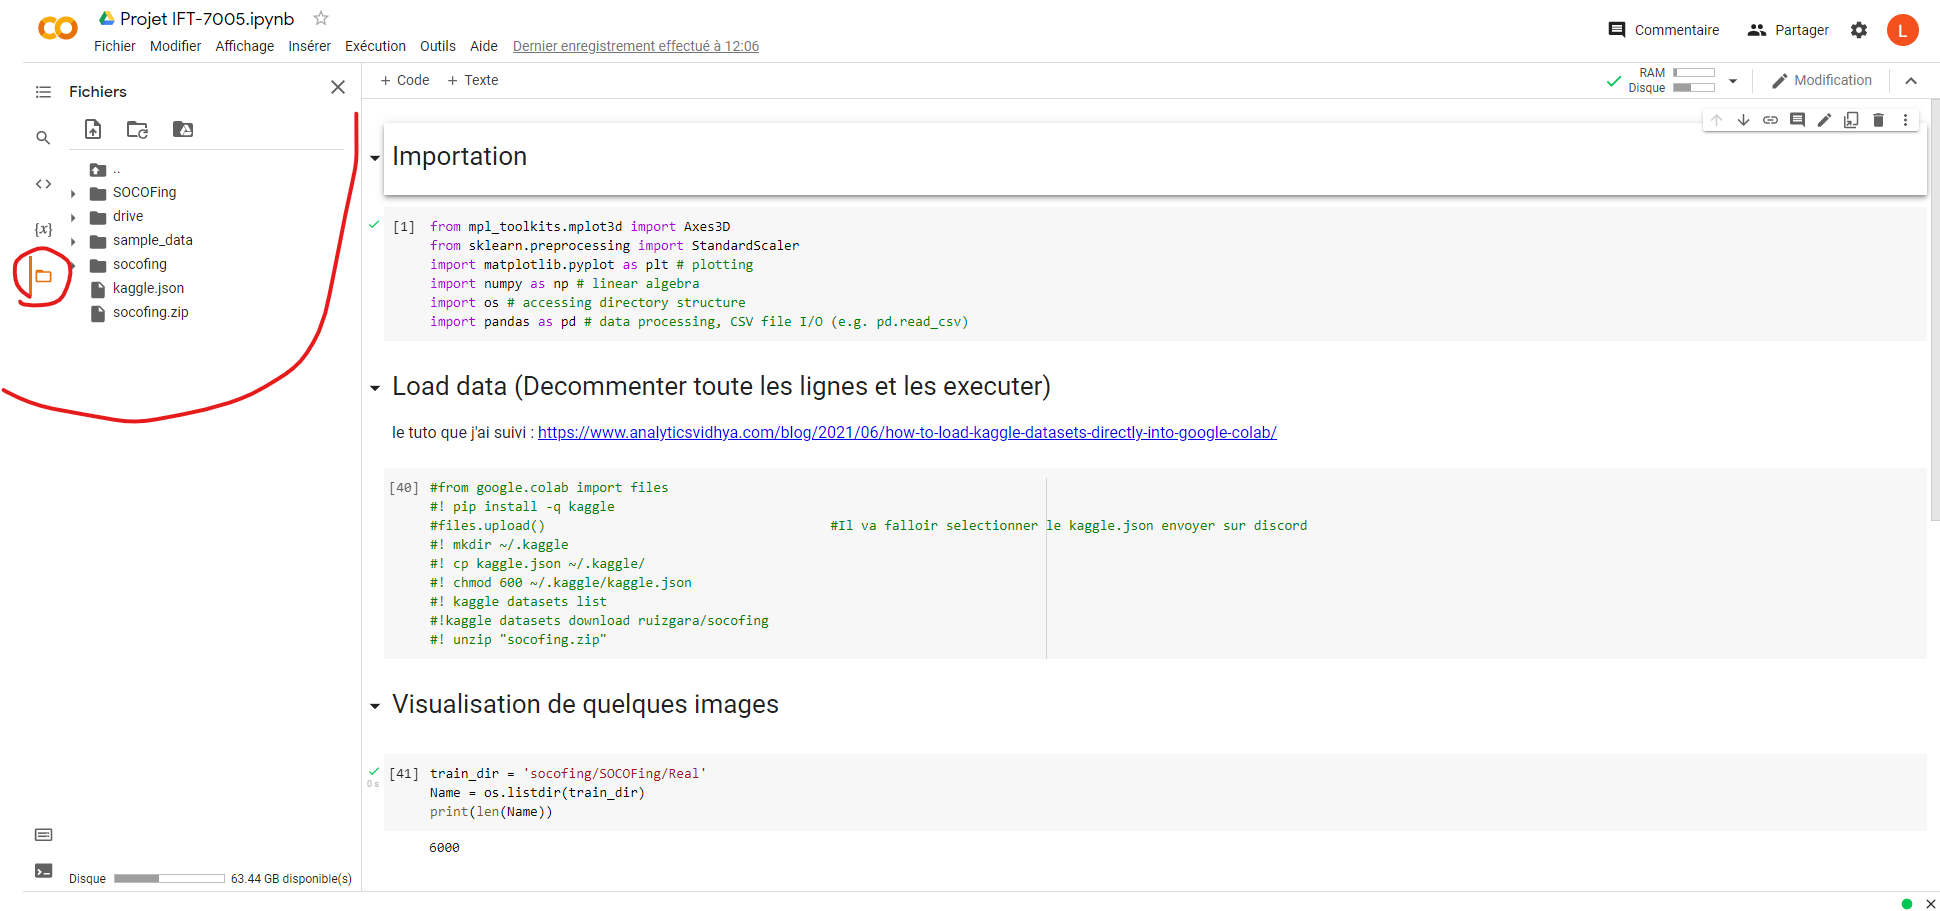  
  
Vous devriez avoir la même chose a l'exception du dossier "drive"

In [ ]:
# from google.colab import files
# ! pip install -q kaggle
# files.upload()                                     #Il va falloir selectionner le kaggle.json envoyé sur discord
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
# !kaggle datasets download ruizgara/socofing
# ! unzip "socofing.zip"

# Load data

In [ ]:
# Chemin vers les données
Real_path = "SOCOfing/Real/"
Easy_path = "SOCOfing/Altered/Altered-Easy/"
Medium_path = "SOCOfing/Altered/Altered-Medium/"
Hard_path = "SOCOfing/Altered/Altered-Hard/"
paths = [Real_path,Easy_path,Medium_path,Hard_path]

In [ ]:
from torch._C import EnumType
# Les images ont 1 x 96 x 103
img_size_init_channel = 1
img_size_init_r = 96
img_size_init_c = 103

# Importation des données dans une liste contenant les informations sur l'image et l'image
# Inspiré de ceci : https://www.kaggle.com/brianzz/subjectid-finger-cnnrecognizer

def load_data(path,ent):
  print("Chargement des images depuis : ", path)
  
  data = []
  TESTING_data = []

  for img in os.listdir(path):
    imgname, ext = os.path.splitext(img)
    
    # ID : Identification de l'image
    ID, etc = imgname.split('__')
    ID = int(ID) - 1

    # gender : 'M' ou 'F'
    # lr : 'Left ou 'Right'
    # finger : 'little', 'ring', 'middle', 'index' ou 'thumb'
    if path == 'SOCOfing/Real/':
      gender, lr, finger, _ = etc.split('_')
    else :
      gender, lr, finger, _, _ = etc.split('_')

    # Endodage du genre :
    # M = 0, F = 1
    if gender == 'F':
      genderNo = 1.
    else : genderNo = 0.

    # Encodage des doigts :
    # Main gauche de 0 à 4, le petit doigt correspond à 0 
    if lr=='Left' :
      base = 0 
    # Main droite de 5 à 9, le petit doigt correspond à 5
    else: base = 5
    if finger =='little':
      fingerNo = base + 0
    elif finger == 'ring':
      fingerNo = base + 1
    elif finger == 'middle':
      fingerNo = base + 2
    elif finger == 'index':
      fingerNo = base + 3
    else : fingerNo = base + 4
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    
    img_resize = cv2.resize(img_array, (img_size_init_c, img_size_init_r))
    
    #séparation des individus 1 à 60 pour le test
    if ID in range (60):
      TESTING_data.append([ID, genderNo, fingerNo, img_resize])
    else :
      data.append([ID, genderNo, fingerNo, img_resize])

  if ent:
    print(len(data), " images ont été chargées. ")
    return data
  else :
    print(len(TESTING_data), " images ont été chargées. ")
    return TESTING_data


Chargement des données pour obtenir la liste avec les informations et les images.  Afin d'obtenir une quantité de données intéressante pour l'entraînement, on ajoute les données altérées aux données réelles.

In [ ]:
# Création du dataset d'entrainement et validation
Easy_data = load_data(Easy_path, ent=True)
Medium_data = load_data(Medium_path,ent=True)
Hard_data = load_data(Hard_path,ent=True)
Real_data = load_data(Real_path,ent=True)

data_socofing = np.concatenate([Easy_data, Medium_data, Hard_data, Real_data], axis=0)
del Easy_data, Medium_data, Hard_data, Real_data

Chargement des images depuis :  SOCOfing/Altered/Altered-Easy/
16152  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Altered/Altered-Medium/
15376  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Altered/Altered-Hard/
12858  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Real/
5400  images ont été chargées. 


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Création du jeu test (toutes les images de 60 individus ont été retirées du jeu d'entraînement/validation)
Easy_data_t = load_data(Easy_path,ent=False)
Medium_data_t = load_data(Medium_path,ent=False)
Hard_data_t = load_data(Hard_path,ent=False)
Real_data_t = load_data(Real_path,ent=False)
TESTING_data_socofing = np.concatenate([Easy_data_t, Medium_data_t, Hard_data_t, Real_data_t], axis=0)
del Easy_data_t, Medium_data_t, Hard_data_t, Real_data_t

Chargement des images depuis :  SOCOfing/Altered/Altered-Easy/
1779  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Altered/Altered-Medium/
1691  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Altered/Altered-Hard/
1414  images ont été chargées. 
Chargement des images depuis :  SOCOfing/Real/
600  images ont été chargées. 


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Visualisation de quelques images

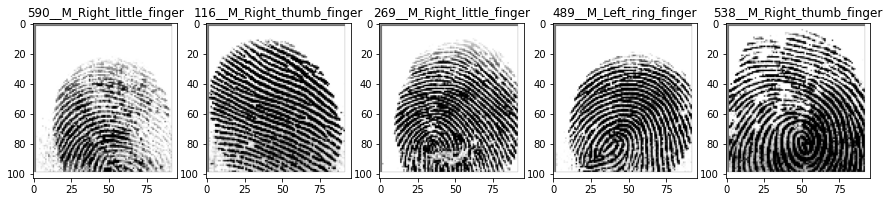

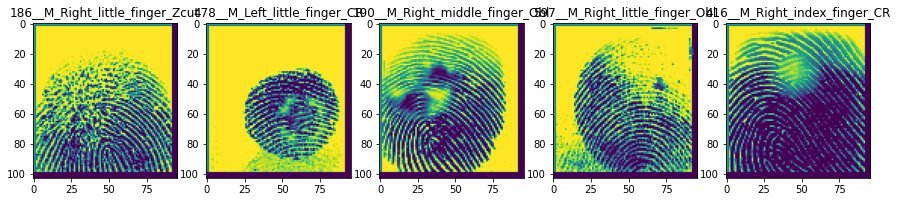

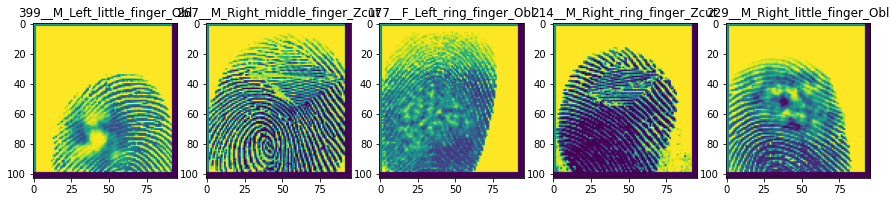

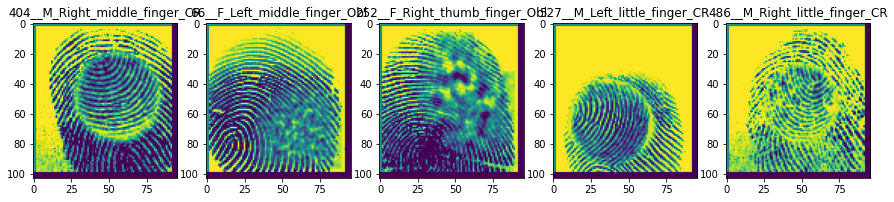

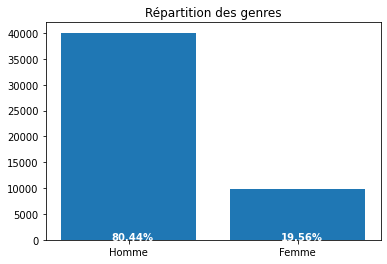

In [ ]:
def visualisation(paths):
  """
  Permet la visualisation de 5 images prises aléatoirement dans un jeu de donnée
  """
  for path in paths:
    Name = os.listdir(path)
    img_array = []
    plt.figure(figsize=(15, 10))
    for i in range(5):
      rand = np.random.randint(0,len(Name))
      img_array.append(plt.imread(path+"/"+Name[rand]))
      plt.subplot(1,5,i+1)
      plt.title(Name[rand][:-4])
      plt.imshow(img_array[i])

def histRepartition(gender):
  """
  Permet la visualisation de la répartition des données selon le genre (H/F)
  le doigt et l'ID est inutile car on à les 10 doigts de 600 personnes
  """
  y_gender = [gender.count(0),gender.count(1)]
  label_gender = ['Homme','Femme']
  
  plt.figure()
  plt.bar(label_gender, y_gender)
  for index, value in enumerate(y_gender):
    percent = value/len(gender)*100
    plt.text(index-0.1, value/y_gender[index], "{:.2f}%".format(percent),fontweight='bold',color='white')
  plt.title("Répartition des genres")

#Visualisation des données
visualisation(paths)
histRepartition([data[1] for data in data_socofing])

# Preprocessing

Chargement des données pour obtenir la liste avec les informations et les images.  Afin d'obtenir une quantité de données intéressante pour l'entraînement, on ajoute les données altérées aux données réelles.

In [ ]:
class socofingDataset(Dataset):
  def __init__(self, X, y, transform, task):
    # Initialisation
    self.X = X
    self.y = y
    self.transform = transform
    self.task = task
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
    image = self.X[index]
    X = self.transform(image)
    target= self.y[index]
    if self.task == 'une classe':
      target = np.expand_dims(target, axis=0)
    return X.float(), target

Division en jeux de données d'entraînement(60%), de validation (30%) et de test (10%)

In [ ]:
data_test = TESTING_data_socofing
data_train, data_valid = train_test_split(data_socofing, test_size = 0.3)
print("Dimension du jeu d'entraînement : ", len(data_train))
print("Dimension du jeu de validation : ", len(data_valid))
print("Dimension du jeu de test : ", len(data_test))

Dimension du jeu d'entraînement :  34850
Dimension du jeu de validation :  14936
Dimension du jeu de test :  5484


## Création des dataloaders

In [ ]:
train_transform = T.Compose([
                            T.ToPILImage(),
                            T.Resize((96, 96)),
                            T.ToTensor(),
                            T.Normalize(0.5, 0.5)])
valid_transform = T.Compose([
                            T.ToPILImage(),
                            T.Resize((96, 96)),
                            T.ToTensor(),
                            T.Normalize(0.5, 0.5)])
test_transform = T.Compose([
                            T.ToPILImage(),
                            T.Resize((96, 96)),
                            T.ToTensor(),
                            T.Normalize(0.5, 0.5)])

RBG_transform = T.Compose([
                            T.ToPILImage(),
                            T.Resize((96, 96)),
                            T.ToTensor(),
                            T.Lambda(lambda x: x.repeat(3, 1, 1) ),
                            T.Normalize(0.5, 0.5)])

batch_size = 64
train_dataset_gender = socofingDataset(data_train[:,3], data_train[:,1], transform=train_transform, task='une classe')
train_dataloader_gender = DataLoader(train_dataset_gender, batch_size, shuffle=True)
valid_dataset_gender = socofingDataset(data_valid[:,3], data_valid[:,1], transform=valid_transform, task = 'une classe')
valid_dataloader_gender = DataLoader(valid_dataset_gender, batch_size, shuffle=True)
test_dataset_gender = socofingDataset(data_test[:,3], data_test[:,1], transform=test_transform, task = 'une classe')
test_dataloader_gender = DataLoader(test_dataset_gender, batch_size, shuffle=True)

train_dataset_finger = socofingDataset(data_train[:,3], data_train[:,2], transform=train_transform, task = 'multi_classe')
train_dataloader_finger = DataLoader(train_dataset_finger, batch_size, shuffle=True)
valid_dataset_finger = socofingDataset(data_valid[:,3], data_valid[:,2], transform=valid_transform, task = 'multi_classe')
valid_dataloader_finger = DataLoader(valid_dataset_finger, batch_size, shuffle=True)
test_dataset_finger = socofingDataset(data_test[:,3], data_test[:,2], transform=test_transform, task = 'multi_classe')
test_dataloader_finger = DataLoader(test_dataset_finger, batch_size, shuffle=True)

train_dataset_id = socofingDataset(data_train[:,3], data_train[:,0], transform=train_transform, task = 'multi_classe')
train_dataloader_id = DataLoader(train_dataset_finger, batch_size, shuffle=True)
valid_dataset_id = socofingDataset(data_valid[:,3], data_valid[:,0], transform=valid_transform, task = 'multi_classe')
valid_dataloader_id = DataLoader(valid_dataset_finger, batch_size, shuffle=True)
test_dataset_id = socofingDataset(data_test[:,3], data_test[:,0], transform=test_transform, task = 'multi_classe')
test_dataloader_id = DataLoader(test_dataset_finger, batch_size, shuffle=True)

#Dataset avec images en RBG pour le réseau Alexnet
RBG_train_dataset_gender = socofingDataset(data_train[:,3], data_train[:,1], transform=RBG_transform, task='une classe')
RBG_train_dataloader_gender = DataLoader(RBG_train_dataset_gender, batch_size, shuffle=True)
RBG_valid_dataset_gender = socofingDataset(data_valid[:,3], data_valid[:,1], transform=RBG_transform, task = 'une classe')
RBG_valid_dataloader_gender = DataLoader(RBG_valid_dataset_gender, batch_size, shuffle=True)
RBG_test_dataset_gender = socofingDataset(data_test[:,3], data_test[:,1], transform=RBG_transform, task = 'une classe')
RBG_test_dataloader_gender = DataLoader(RBG_test_dataset_gender, batch_size, shuffle=True)

RBG_train_dataset_finger = socofingDataset(data_train[:,3], data_train[:,2], transform=RBG_transform, task = 'multi_classe')
RBG_train_dataloader_finger = DataLoader(RBG_train_dataset_finger, batch_size, shuffle=True)
RBG_valid_dataset_finger = socofingDataset(data_valid[:,3], data_valid[:,2], transform=RBG_transform, task = 'multi_classe')
RBG_valid_dataloader_finger = DataLoader(RBG_valid_dataset_finger, batch_size, shuffle=True)
RBG_test_dataset_finger = socofingDataset(data_test[:,3], data_test[:,2], transform=RBG_transform, task = 'multi_classe')
RBG_test_dataloader_finger = DataLoader(RBG_test_dataset_finger, batch_size, shuffle=True)

RBG_train_dataset_id = socofingDataset(data_train[:,3], data_train[:,0], transform=RBG_transform, task = 'multi_classe')
RBG_train_dataloader_id = DataLoader(RBG_train_dataset_finger, batch_size, shuffle=True)
RBG_valid_dataset_id = socofingDataset(data_valid[:,3], data_valid[:,0], transform=RBG_transform, task = 'multi_classe')
RBG_valid_dataloader_id = DataLoader(RBG_valid_dataset_finger, batch_size, shuffle=True)
RBG_test_dataset_id = socofingDataset(data_test[:,3], data_test[:,0], transform=RBG_transform, task = 'multi_classe')
RBG_test_dataloader_id = DataLoader(RBG_test_dataset_finger, batch_size, shuffle=True)

### On vérifie que le datalaoder fonctionne et que les images et les valeurs cibles ont les dimensions voulues

In [ ]:
batch = next(iter(train_dataloader_gender))
image, target = batch
print(image.dtype)
print(target.dtype)
batch = next(iter(train_dataloader_finger))
image, target = batch
print(image.shape)
print(target.dtype)
batch = next(iter(train_dataloader_id))
image, target = batch
print(image.shape)
print(target.dtype)

torch.float32
torch.float64
torch.Size([64, 1, 96, 96])
torch.int64
torch.Size([64, 1, 96, 96])
torch.int64


# Training 

## Création du dossier d'enregistrement

In [ ]:
dossier = 'saves'
save_path = os.path.join(dossier, 'socoFING')
os.makedirs(save_path, exist_ok=True)

## Transfer learning avec Resnet

### Préparation du Resnet

In [ ]:
def prepResnet(resnet, nombre_classes):
  
  # On doit adapter le modèle au fait qu'on a q'un seul channel
  resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  
  dim_before_fc = resnet.fc.in_features
  resnet.fc = torch.nn.Linear(dim_before_fc, nombre_classes, bias = True)
  # On ne gèle pas les couches car on ne veut pas conserver les poids pré-entraînés pour des images de 224x224 pixels
  # for name, param in resnet.named_parameters():
  #   param.requires_grad = False
  #   if (name == 'fc.weight') or (name == 'fc.bias'):
  #     param.requires_grad = True

### Apprentissage genre

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 8
*   Learning rate initial : $\eta = 10^{-2}$
*   Momentum              : $\gamma = 0.0$

Résultats
*   Temps d'entrainement : $\approx 12$ min (1min30/epoch)

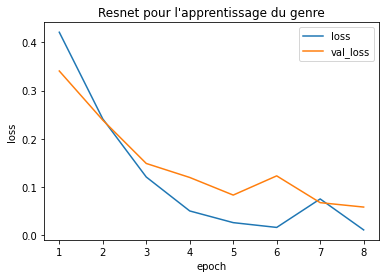


In [ ]:
# Apprentissage du genre
model_resnet_gender = resnet18(pretrained=True, progress=False)
prepResnet(model_resnet_gender, 1)

n_epoch = 8
learning_rate = 0.01
momentum = 0
criterion = torch.nn.BCEWithLogitsLoss()
param = filter(lambda x: x.requires_grad, model_resnet_gender.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate, momentum=momentum)

callbacks = [
  # Save the losses and accuracies for each epoch in a TSV.
  CSVLogger(os.path.join(save_path, 'log_resnet_gender.tsv'), separator='\t'),

  # Réduire le learning rate
  ReduceLROnPlateau(patience=3)
]

model_fit_resnet_gender = Model(model_resnet_gender, optimizer, criterion, batch_metrics=['binary_accuracy'], device=DEVICE)
model_fit_resnet_gender.fit_generator(train_dataloader_gender, valid_dataloader_gender, epochs=n_epoch, callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Epoch: 1/8 Train steps: 545 Val steps: 234 1m38.64s loss: 0.402179 bin_acc: 82.599713 val_loss: 0.352309 val_bin_acc: 84.426888
Epoch: 2/8 Train steps: 545 Val steps: 234 1m39.39s loss: 0.203575 bin_acc: 91.882353 val_loss: 0.235867 val_bin_acc: 90.245046
Epoch: 3/8 Train steps: 545 Val steps: 234 1m39.76s loss: 0.077731 bin_acc: 97.245337 val_loss: 0.246281 val_bin_acc: 90.546331
Epoch: 4/8 Train steps: 545 Val steps: 234 1m44.24s loss: 0.029484 bin_acc: 99.147776 val_loss: 0.084970 val_bin_acc: 97.027317
Epoch: 5/8 Train steps: 545 Val steps: 234 1m46.04s loss: 0.014758 bin_acc: 99.583931 val_loss: 0.044018 val_bin_acc: 98.406535
Epoch: 6/8 Train steps: 545 Val steps: 234 1m40.51s loss: 0.011182 bin_acc: 99.695839 val_loss: 0.037115 val_bin_acc: 98.821639
Epoch: 7/8 Train steps: 545 Val steps: 234 1m40.05s loss: 0.006707 bin_acc: 99.833572 val_loss: 0.186465 val_bin_acc: 95.386984
Epoch: 8/8 Train steps: 545 Val steps: 234 1m40.36s loss: 0.005988 bin_acc: 99.839311 val_loss: 0.039494

[{'bin_acc': 82.59971305989467,
  'epoch': 1,
  'loss': 0.40217949450625784,
  'time': 98.6361579559998,
  'val_bin_acc': 84.42688805570434,
  'val_loss': 0.35230906869567874},
 {'bin_acc': 91.88235294511705,
  'epoch': 2,
  'loss': 0.20357506539472114,
  'time': 99.38531617400031,
  'val_bin_acc': 90.24504553167081,
  'val_loss': 0.235866891878328},
 {'bin_acc': 97.24533715750258,
  'epoch': 3,
  'loss': 0.07773080295998813,
  'time': 99.76086860800024,
  'val_bin_acc': 90.54633101231923,
  'val_loss': 0.24628121781268655},
 {'bin_acc': 99.14777619021181,
  'epoch': 4,
  'loss': 0.02948351480578104,
  'time': 104.23518649700009,
  'val_bin_acc': 97.02731655061596,
  'val_loss': 0.08497017985587907},
 {'bin_acc': 99.58393113342898,
  'epoch': 5,
  'loss': 0.014758047181610015,
  'time': 106.03750333200014,
  'val_bin_acc': 98.40653455148869,
  'val_loss': 0.044018056229287776},
 {'bin_acc': 99.6958393113343,
  'epoch': 6,
  'loss': 0.011181774206922023,
  'time': 100.50631588099986,
  

### Apprentissage doigt

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 10
*   Learning rate initial : $\eta = 10^{-2}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 15$ min (1min30/epoch)

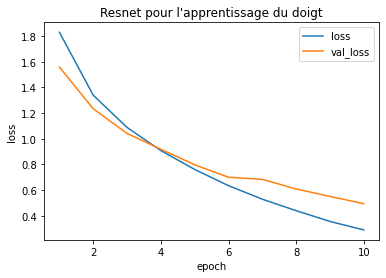

In [ ]:
# Apprentissage du doigt
model_resnet_finger = resnet18(pretrained=True)
prepResnet(model_resnet_finger, 10)

n_epoch = 10
learning_rate = 0.01

criterion = torch.nn.CrossEntropyLoss()
param = filter(lambda x: x.requires_grad, model_resnet_finger.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_resnet_finger.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

   # Save the losses and accuracies for each epoch in a TSV.
   CSVLogger(os.path.join(save_path, 'log_resnet_finger.tsv'), separator='\t'),

   # Réduire le learning rate
   ReduceLROnPlateau(patience=3)
 ]

model_fit_resnet_finger = Model(model_resnet_finger, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_resnet_finger.fit_generator(train_dataloader_finger, valid_dataloader_finger, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/10 Train steps: 545 Val steps: 234 1m40.36s loss: 1.045719 acc: 63.302726 fscore_micro: 0.633027 val_loss: 0.678884 val_acc: 76.707284 val_fscore_micro: 0.767073
Epoch 1: val_acc improved from -inf to 76.70728, saving file to saves/socoFING/best_epoch_1_resnet_finger.ckpt
Epoch:  2/10 Train steps: 545 Val steps: 234 1m40.01s loss: 0.385430 acc: 87.130560 fscore_micro: 0.871306 val_loss: 0.355309 val_acc: 88.129352 val_fscore_micro: 0.881294
Epoch 2: val_acc improved from 76.70728 to 88.12935, saving file to saves/socoFING/best_epoch_2_resnet_finger.ckpt
Epoch:  3/10 Train steps: 545 Val steps: 234 1m40.30s loss: 0.131556 acc: 96.476327 fscore_micro: 0.964763 val_loss: 0.176640 val_acc: 94.068024 val_fscore_micro: 0.940680
Epoch 3: val_acc improved from 88.12935 to 94.06802, saving file to saves/socoFING/best_epoch_3_resnet_finger.ckpt
Epoch:  4/10 Train steps: 545 Val steps: 234 1m40.19s loss: 0.049810 acc: 98.944046 fscore_micro: 0.989440 val_loss: 0.127294 val_acc: 95.86234

[{'acc': 63.302725968874,
  'epoch': 1,
  'fscore_micro': 0.6330272555351257,
  'loss': 1.0457194071383866,
  'time': 100.3623887220001,
  'val_acc': 76.70728441349759,
  'val_fscore_micro': 0.767072856426239,
  'val_loss': 0.6788843977112916},
 {'acc': 87.13055954001385,
  'epoch': 2,
  'fscore_micro': 0.871305525302887,
  'loss': 0.38542971999008996,
  'time': 100.00660375700045,
  'val_acc': 88.12935190961906,
  'val_fscore_micro': 0.8812935948371887,
  'val_loss': 0.35530867299487007},
 {'acc': 96.47632711533666,
  'epoch': 3,
  'fscore_micro': 0.9647632837295532,
  'loss': 0.1315562525575438,
  'time': 100.30423704700024,
  'val_acc': 94.06802356722014,
  'val_fscore_micro': 0.9406802654266357,
  'val_loss': 0.17663971518665697},
 {'acc': 98.94404591017167,
  'epoch': 4,
  'fscore_micro': 0.9894404411315918,
  'loss': 0.04981045456023264,
  'time': 100.19102179499987,
  'val_acc': 95.86234600964113,
  'val_fscore_micro': 0.958623468875885,
  'val_loss': 0.1272940961918412},
 {'acc

### Apprentissage ID

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 15
*   Learning rate initial : $\eta = 10^{-3}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 23$ min (1min30/epoch)

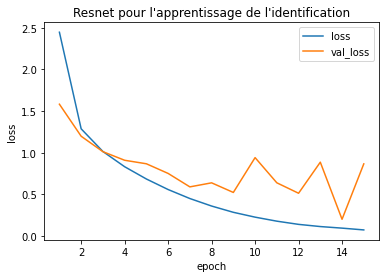

In [ ]:
# Apprentissage de l'identification
model_resnet_id = resnet18(pretrained=True)
prepResnet(model_resnet_id, 600)

n_epoch = 15
learning_rate = 0.01

criterion = torch.nn.CrossEntropyLoss()
param = filter(lambda x: x.requires_grad, model_resnet_id.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_resnet_id.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

   # Save the losses and accuracies for each epoch in a TSV.
   CSVLogger(os.path.join(save_path, 'log_resnet_id.tsv'), separator='\t'),

   # Réduire le learning rate
   ReduceLROnPlateau(patience=3)
 ]

model_fit_resnet_id = Model(model_resnet_id, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_resnet_id.fit_generator(train_dataloader_id, valid_dataloader_id, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/15 Train steps: 545 Val steps: 234 1m40.11s loss: 1.065319 acc: 65.070301 fscore_micro: 0.650703 val_loss: 0.732411 val_acc: 73.654258 val_fscore_micro: 0.736543
Epoch 1: val_acc improved from -inf to 73.65426, saving file to saves/socoFING/best_epoch_1_resnet_id.ckpt
Epoch:  2/15 Train steps: 545 Val steps: 234 1m39.72s loss: 0.355110 acc: 88.571019 fscore_micro: 0.885710 val_loss: 1.248514 val_acc: 61.475629 val_fscore_micro: 0.614756
Epoch:  3/15 Train steps: 545 Val steps: 234 1m40.01s loss: 0.119289 acc: 96.860832 fscore_micro: 0.968608 val_loss: 0.195220 val_acc: 93.760043 val_fscore_micro: 0.937600
Epoch 3: val_acc improved from 73.65426 to 93.76004, saving file to saves/socoFING/best_epoch_3_resnet_id.ckpt
Epoch:  4/15 Train steps: 545 Val steps: 234 1m40.11s loss: 0.055140 acc: 98.691535 fscore_micro: 0.986915 val_loss: 0.248934 val_acc: 91.805035 val_fscore_micro: 0.918050
Epoch:  5/15 Train steps: 545 Val steps: 234 1m40.05s loss: 0.024944 acc: 99.517934 fscore_mic

[{'acc': 65.07030128686979,
  'epoch': 1,
  'fscore_micro': 0.6507030129432678,
  'loss': 1.0653188222176375,
  'time': 100.11008250500072,
  'val_acc': 73.65425816614103,
  'val_fscore_micro': 0.7365425229072571,
  'val_loss': 0.7324106419986751},
 {'acc': 88.57101865267651,
  'epoch': 2,
  'fscore_micro': 0.8857101798057556,
  'loss': 0.355109528103039,
  'time': 99.72228830899985,
  'val_acc': 61.475629351901446,
  'val_fscore_micro': 0.6147562861442566,
  'val_loss': 1.2485135171141417},
 {'acc': 96.86083213598178,
  'epoch': 3,
  'fscore_micro': 0.9686083197593689,
  'loss': 0.11928913335974624,
  'time': 100.01490061200002,
  'val_acc': 93.76004285766406,
  'val_fscore_micro': 0.9376004338264465,
  'val_loss': 0.1952197122969727},
 {'acc': 98.69153515064562,
  'epoch': 4,
  'fscore_micro': 0.9869153499603271,
  'loss': 0.055140438401587895,
  'time': 100.11465777600006,
  'val_acc': 91.80503480703868,
  'val_fscore_micro': 0.9180504083633423,
  'val_loss': 0.24893423166658768},
 

## Apprentissage avec un réseau simple

### Préparation du réseau

In [ ]:
class reseau(torch.nn.Module):
    def __init__(self, num_classes):
        super(reseau, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU())

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64 * 44 * 44, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x).double()

        return x

### Apprentissage genre

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 15
*   Learning rate initial : $\eta = 10^{-3}$
*   Momentum              : $\gamma = 0.9$

Résultats
*   Temps d'entrainement : $\approx 15$ min (1min/epoch)

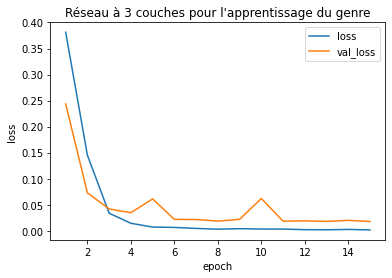




In [ ]:
# # Apprentissage du genre
model_reseau_gender = reseau(num_classes=1)

n_epoch = 15
learning_rate = 0.001
momentum = 0.9
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_reseau_gender.parameters(), lr=learning_rate, momentum=momentum)

callbacks = [
  # Save the losses and accuracies for each epoch in a TSV.
  CSVLogger(os.path.join(save_path, 'log_reseau_gender.tsv'), separator='\t'),

  # Réduire le learning rate
  ReduceLROnPlateau(patience=3)
]

model_fit_reseau_gender = Model(model_reseau_gender, optimizer, criterion, batch_metrics=['binary_accuracy'], device=DEVICE)
model_fit_reseau_gender.fit_generator(train_dataloader_gender, valid_dataloader_gender, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/15 Train steps: 545 Val steps: 234 1m1.45s loss: 0.370466 bin_acc: 83.784792 val_loss: 0.273677 val_bin_acc: 86.268077
Epoch:  2/15 Train steps: 545 Val steps: 234 1m1.81s loss: 0.105236 bin_acc: 96.665710 val_loss: 0.052054 val_bin_acc: 98.573915
Epoch:  3/15 Train steps: 545 Val steps: 234 1m1.94s loss: 0.021862 bin_acc: 99.724534 val_loss: 0.034806 val_bin_acc: 99.343867
Epoch:  4/15 Train steps: 545 Val steps: 234 1m1.85s loss: 0.009141 bin_acc: 99.951220 val_loss: 0.020834 val_bin_acc: 99.511248
Epoch:  5/15 Train steps: 545 Val steps: 234 1m1.90s loss: 0.005468 bin_acc: 99.965567 val_loss: 0.020961 val_bin_acc: 99.511248
Epoch:  6/15 Train steps: 545 Val steps: 234 1m1.87s loss: 0.005370 bin_acc: 99.962697 val_loss: 0.019713 val_bin_acc: 99.484467
Epoch:  7/15 Train steps: 545 Val steps: 234 1m2.18s loss: 0.003496 bin_acc: 99.977044 val_loss: 0.016920 val_bin_acc: 99.604981
Epoch:  8/15 Train steps: 545 Val steps: 234 1m2.29s loss: 0.003862 bin_acc: 99.968436 val_loss: 

[{'bin_acc': 83.78479197213434,
  'epoch': 1,
  'loss': 0.37046609372715184,
  'time': 61.44659819300068,
  'val_bin_acc': 86.26807712908409,
  'val_loss': 0.2736768616488276},
 {'bin_acc': 96.66571018651364,
  'epoch': 2,
  'loss': 0.10523564423035209,
  'time': 61.812576564000665,
  'val_bin_acc': 98.57391537225496,
  'val_loss': 0.05205376666495804},
 {'bin_acc': 99.72453371592539,
  'epoch': 3,
  'loss': 0.021862329723082725,
  'time': 61.93628758000068,
  'val_bin_acc': 99.3438671665774,
  'val_loss': 0.0348063932724587},
 {'bin_acc': 99.95121951219512,
  'epoch': 4,
  'loss': 0.00914108335266317,
  'time': 61.848065778999626,
  'val_bin_acc': 99.5112479914301,
  'val_loss': 0.020833536518599753},
 {'bin_acc': 99.96556671449068,
  'epoch': 5,
  'loss': 0.005467902234554561,
  'time': 61.89783220499976,
  'val_bin_acc': 99.51124799551654,
  'val_loss': 0.020961043833312668},
 {'bin_acc': 99.96269727403157,
  'epoch': 6,
  'loss': 0.005370447165409775,
  'time': 61.86639490200014,
 

### Apprentissage doigt

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 10
*   Learning rate initial : $\eta = 10^{-2}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 10$ min (1min/epoch)

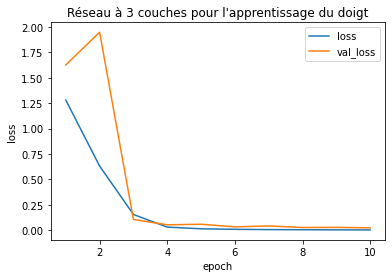

In [ ]:
# Apprentissage des doigts
model_reseau_finger = reseau(num_classes=10)

n_epoch = 10
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_reseau_finger.parameters(), lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_reseau_finger.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

  # Save the losses and accuracies for each epoch in a TSV.
  CSVLogger(os.path.join(save_path, 'log_reseau_finger.tsv'), separator='\t'),

  # Réduire le learning rate
  ReduceLROnPlateau(patience=3)
]

model_fit_reseau_finger = Model(model_reseau_finger, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_reseau_finger.fit_generator(train_dataloader_finger, valid_dataloader_finger, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/10 Train steps: 545 Val steps: 234 1m1.07s loss: 1.265552 acc: 54.068867 fscore_micro: 0.540689 val_loss: 1.519256 val_acc: 47.797268 val_fscore_micro: 0.477973
Epoch 1: val_acc improved from -inf to 47.79727, saving file to saves/socoFING/best_epoch_1_reseau_finger.ckpt
Epoch:  2/10 Train steps: 545 Val steps: 234 1m1.38s loss: 0.528963 acc: 82.482066 fscore_micro: 0.824821 val_loss: 0.327010 val_acc: 90.211569 val_fscore_micro: 0.902116
Epoch 2: val_acc improved from 47.79727 to 90.21157, saving file to saves/socoFING/best_epoch_2_reseau_finger.ckpt
Epoch:  3/10 Train steps: 545 Val steps: 234 1m1.00s loss: 0.588442 acc: 83.779053 fscore_micro: 0.837791 val_loss: 0.845987 val_acc: 69.590252 val_fscore_micro: 0.695903
Epoch:  4/10 Train steps: 545 Val steps: 234 1m1.71s loss: 0.363387 acc: 89.400287 fscore_micro: 0.894003 val_loss: 0.143786 val_acc: 96.913498 val_fscore_micro: 0.969135
Epoch 4: val_acc improved from 90.21157 to 96.91350, saving file to saves/socoFING/best_ep

[{'acc': 54.0688665736457,
  'epoch': 1,
  'fscore_micro': 0.540688693523407,
  'loss': 1.2655515171150613,
  'time': 61.06726899499972,
  'val_acc': 47.79726834391679,
  'val_fscore_micro': 0.47797268629074097,
  'val_loss': 1.5192561465699992},
 {'acc': 82.48206599537919,
  'epoch': 2,
  'fscore_micro': 0.8248206377029419,
  'loss': 0.5289632600237687,
  'time': 61.375533049000296,
  'val_acc': 90.21156936261382,
  'val_fscore_micro': 0.9021157026290894,
  'val_loss': 0.32701025436512315},
 {'acc': 83.77905308202145,
  'epoch': 3,
  'fscore_micro': 0.8377906084060669,
  'loss': 0.5884424735338504,
  'time': 61.00289572899965,
  'val_acc': 69.59025174893347,
  'val_fscore_micro': 0.6959025263786316,
  'val_loss': 0.8459868599307085},
 {'acc': 89.40028694404592,
  'epoch': 4,
  'fscore_micro': 0.8940028548240662,
  'loss': 0.36338662364439045,
  'time': 61.71166012999947,
  'val_acc': 96.91349758971612,
  'val_fscore_micro': 0.9691349864006042,
  'val_loss': 0.1437863373453869},
 {'acc

### Apprentissage ID

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 15
*   Learning rate initial : $\eta = 10^{-2}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 15$ min (1min/epoch)
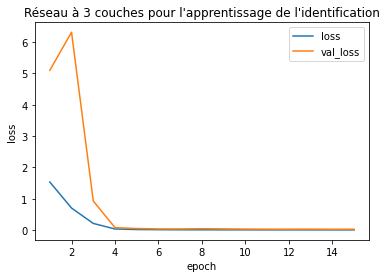

In [ ]:
# Apprentissage de l'identification
model_reseau_id = reseau(num_classes=600)

n_epoch = 15
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_reseau_id.parameters(), lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_reseau_id.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

  # Save the losses and accuracies for each epoch in a TSV.
  CSVLogger(os.path.join(save_path, 'log_reseau_id.tsv'), separator='\t'),

  # Réduire le learning rate
  ReduceLROnPlateau(patience=3)
]

model_fit_reseau_id = Model(model_reseau_id, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_reseau_id.fit_generator(train_dataloader_id, valid_dataloader_id, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/15 Train steps: 545 Val steps: 234 1m0.34s loss: 1.383290 acc: 52.774749 fscore_micro: 0.527748 val_loss: 0.933938 val_acc: 66.624264 val_fscore_micro: 0.666243
Epoch 1: val_acc improved from -inf to 66.62426, saving file to saves/socoFING/best_epoch_1_reseau_id.ckpt
Epoch:  2/15 Train steps: 545 Val steps: 234 1m0.48s loss: 0.540639 acc: 82.430416 fscore_micro: 0.824304 val_loss: 0.305506 val_acc: 90.445903 val_fscore_micro: 0.904459
Epoch 2: val_acc improved from 66.62426 to 90.44590, saving file to saves/socoFING/best_epoch_2_reseau_id.ckpt
Epoch:  3/15 Train steps: 545 Val steps: 234 1m0.75s loss: 0.073586 acc: 98.981349 fscore_micro: 0.989814 val_loss: 0.069748 val_acc: 98.761382 val_fscore_micro: 0.987614
Epoch 3: val_acc improved from 90.44590 to 98.76138, saving file to saves/socoFING/best_epoch_3_reseau_id.ckpt
Epoch:  4/15 Train steps: 545 Val steps: 234 1m0.93s loss: 0.020727 acc: 99.888092 fscore_micro: 0.998881 val_loss: 0.042350 val_acc: 99.250134 val_fscore_mic

[{'acc': 52.774748921770616,
  'epoch': 1,
  'fscore_micro': 0.5277475118637085,
  'loss': 1.3832899694015004,
  'time': 60.340294153000286,
  'val_acc': 66.62426353254354,
  'val_fscore_micro': 0.6662426590919495,
  'val_loss': 0.9339380526193601},
 {'acc': 82.43041607280715,
  'epoch': 2,
  'fscore_micro': 0.8243041634559631,
  'loss': 0.5406392138103728,
  'time': 60.47984104900024,
  'val_acc': 90.44590250923471,
  'val_fscore_micro': 0.9044589996337891,
  'val_loss': 0.30550568985626625},
 {'acc': 98.98134863701578,
  'epoch': 3,
  'fscore_micro': 0.989813506603241,
  'loss': 0.07358627459749077,
  'time': 60.7492902289996,
  'val_acc': 98.7613818879171,
  'val_fscore_micro': 0.9876137971878052,
  'val_loss': 0.06974823065900848},
 {'acc': 99.8880918220947,
  'epoch': 4,
  'fscore_micro': 0.998880922794342,
  'loss': 0.02072682892613879,
  'time': 60.93403304899948,
  'val_acc': 99.25013390465988,
  'val_fscore_micro': 0.9925013184547424,
  'val_loss': 0.04234955967561565},
 {'acc

## Apprentissage avec Alexnet

### Préparation du AlexNet

In [ ]:
def prepAlexnet(alexnet, nombre_classes):  
  # On modifie la taille de sortie de la dernière couche pour le nombre de classes
  alexnet.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(in_features=9216, out_features=4096, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=4096, out_features=nombre_classes, bias=True))
        
  # # On ne gèle pas les couches car on ne veut pas conserver les poids pré-entraînés pour des images de 226x226 pixels
  #for name, param in alexnet.named_parameters():
  #  if name.startswith("class") == False:
  #    param.requires_grad = False

### Apprentissage genre

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 5
*   Learning rate initial : $\eta = 10^{-3}$
*   Momentum              : $\gamma = 0.9$

Résultats
*   Temps d'entrainement : $\approx 5$ min (1min/epoch)


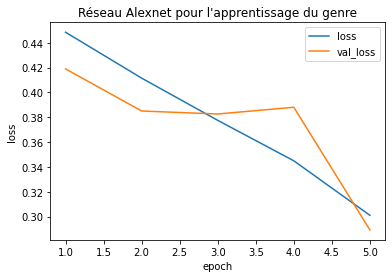

In [ ]:
# Apprentissage du genre
model_alexnet_gender = alexnet(pretrained=True)
prepAlexnet(model_alexnet_gender, 1)

n_epoch = 5
learning_rate = 0.001
momentum = 0.9
criterion = torch.nn.BCEWithLogitsLoss()
param = filter(lambda x: x.requires_grad, model_alexnet_gender.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate, momentum=momentum)

callbacks = [
  # Save the losses and accuracies for each epoch in a TSV.
  CSVLogger(os.path.join(save_path, 'log_alexnet_gender.tsv'), separator='\t'),

  # Réduire le learning rate
  ReduceLROnPlateau(patience=3)
]

model_fit_alexnet_gender = Model(model_alexnet_gender, optimizer, criterion, batch_metrics=['binary_accuracy'], device=DEVICE)
model_fit_alexnet_gender.fit_generator(RBG_train_dataloader_gender, RBG_valid_dataloader_gender, epochs=n_epoch, callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch: 1/5 Train steps: 545 Val steps: 234 1m9.21s loss: 0.444005 bin_acc: 81.078910 val_loss: 0.415282 val_bin_acc: 82.029995
Epoch: 2/5 Train steps: 545 Val steps: 234 1m8.03s loss: 0.404324 bin_acc: 82.502152 val_loss: 0.394701 val_bin_acc: 83.194965
Epoch: 3/5 Train steps: 545 Val steps: 234 1m7.77s loss: 0.370485 bin_acc: 84.022956 val_loss: 0.369603 val_bin_acc: 83.643546
Epoch: 4/5 Train steps: 545 Val steps: 234 1m7.54s loss: 0.330800 bin_acc: 85.670014 val_loss: 0.331650 val_bin_acc: 85.692287
Epoch: 5/5 Train steps: 545 Val steps: 234 1m7.28s loss: 0.280879 bin_acc: 88.200861 val_loss: 0.298189 val_bin_acc: 87.727638


[{'bin_acc': 81.07890961393906,
  'epoch': 1,
  'loss': 0.4440049795286698,
  'time': 69.21307567499935,
  'val_bin_acc': 82.0299946519865,
  'val_loss': 0.4152822401810902},
 {'bin_acc': 82.50215207596591,
  'epoch': 2,
  'loss': 0.4043236334434189,
  'time': 68.02957125300054,
  'val_bin_acc': 83.19496518478843,
  'val_loss': 0.3947006661981336},
 {'bin_acc': 84.02295551929447,
  'epoch': 3,
  'loss': 0.370484890635654,
  'time': 67.76821150400065,
  'val_bin_acc': 83.64354579948012,
  'val_loss': 0.3696034218480782},
 {'bin_acc': 85.67001434545092,
  'epoch': 4,
  'loss': 0.3307996048060254,
  'time': 67.53788177800016,
  'val_bin_acc': 85.69228709567723,
  'val_loss': 0.3316496157406631},
 {'bin_acc': 88.20086082951069,
  'epoch': 5,
  'loss': 0.28087926951983877,
  'time': 67.27652374700119,
  'val_bin_acc': 87.72763792588613,
  'val_loss': 0.2981894408615462}]

### Apprentissage doigt

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 20
*   Learning rate initial : $\eta = 7.10^{-3}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 20$ min (1min/epoch)

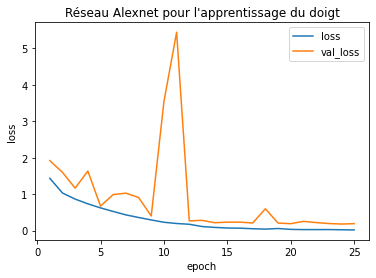

In [ ]:
# Apprentissage du doigt
model_alexnet_finger = alexnet(pretrained=True)
prepAlexnet(model_alexnet_finger, 10)

n_epoch = 20
learning_rate = 0.007

criterion = torch.nn.CrossEntropyLoss()
param = filter(lambda x: x.requires_grad, model_alexnet_finger.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_alexnet_finger.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

   # Save the losses and accuracies for each epoch in a TSV.
   CSVLogger(os.path.join(save_path, 'log_alexnet_finger.tsv'), separator='\t'),

   # Réduire le learning rate
   ReduceLROnPlateau(patience=3)
 ]

model_fit_alexnet_finger = Model(model_alexnet_finger, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_alexnet_finger.fit_generator(RBG_train_dataloader_finger, RBG_valid_dataloader_finger, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/20 Train steps: 545 Val steps: 234 1m4.91s loss: 1.432854 acc: 47.512195 fscore_micro: 0.475122 val_loss: 1.107316 val_acc: 58.877879 val_fscore_micro: 0.588779
Epoch 1: val_acc improved from -inf to 58.87788, saving file to saves/socoFING/best_epoch_1_alexnet_finger.ckpt
Epoch:  2/20 Train steps: 545 Val steps: 234 1m6.36s loss: 1.011697 acc: 62.886657 fscore_micro: 0.628867 val_loss: 0.857158 val_acc: 68.867167 val_fscore_micro: 0.688672
Epoch 2: val_acc improved from 58.87788 to 68.86717, saving file to saves/socoFING/best_epoch_2_alexnet_finger.ckpt
Epoch:  3/20 Train steps: 545 Val steps: 234 1m6.19s loss: 0.840060 acc: 69.268293 fscore_micro: 0.692683 val_loss: 0.849519 val_acc: 68.626138 val_fscore_micro: 0.686261
Epoch:  4/20 Train steps: 545 Val steps: 234 1m6.03s loss: 0.698259 acc: 74.645624 fscore_micro: 0.746456 val_loss: 0.698445 val_acc: 73.908677 val_fscore_micro: 0.739087
Epoch 4: val_acc improved from 68.86717 to 73.90868, saving file to saves/socoFING/best_

[{'acc': 47.51219512195122,
  'epoch': 1,
  'fscore_micro': 0.47512194514274597,
  'loss': 1.4328538335994463,
  'time': 64.90674391300126,
  'val_acc': 58.877878950187466,
  'val_fscore_micro': 0.5887787938117981,
  'val_loss': 1.107316498776841},
 {'acc': 62.886657102302976,
  'epoch': 2,
  'fscore_micro': 0.6288665533065796,
  'loss': 1.0116971670161703,
  'time': 66.36027872100021,
  'val_acc': 68.86716658556979,
  'val_fscore_micro': 0.6886716485023499,
  'val_loss': 0.8571579444197709},
 {'acc': 69.26829268095653,
  'epoch': 3,
  'fscore_micro': 0.6926829218864441,
  'loss': 0.8400598833584888,
  'time': 66.1945023010012,
  'val_acc': 68.626138189609,
  'val_fscore_micro': 0.6862613558769226,
  'val_loss': 0.8495193371238974},
 {'acc': 74.64562410548906,
  'epoch': 4,
  'fscore_micro': 0.7464562654495239,
  'loss': 0.6982592218661069,
  'time': 66.02563497799929,
  'val_acc': 73.90867702196036,
  'val_fscore_micro': 0.7390867471694946,
  'val_loss': 0.6984446572312456},
 {'acc': 

### Apprentissage ID

Hyper-paramètre 

*   Taille batch          : 64
*   Nombre d'epoch        : 15
*   Learning rate initial : $\eta = 5.10^{-3}$
*   Momentum              : $\gamma = 0$

Résultats
*   Temps d'entrainement : $\approx 15$ min (1min/epoch)

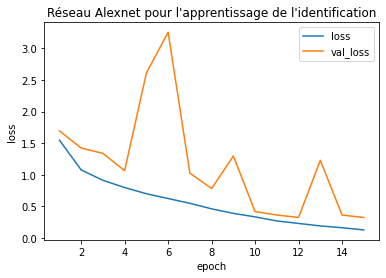

In [ ]:
# Apprentissage de l'identification
model_alexnet_id = alexnet(pretrained=True)
prepAlexnet(model_alexnet_id, 600)

n_epoch = 15
learning_rate = 0.005

criterion = torch.nn.CrossEntropyLoss()
param = filter(lambda x: x.requires_grad, model_alexnet_id.parameters())
optimizer = torch.optim.SGD(param, lr=learning_rate)

callbacks = [
  # Save the weights in a new file when the current model is better than all previous models.
  ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}_alexnet_id.ckpt'), monitor='val_acc', mode='max',
                  save_best_only=True, restore_best=True, verbose=True),

   # Save the losses and accuracies for each epoch in a TSV.
   CSVLogger(os.path.join(save_path, 'log_alexnet_id.tsv'), separator='\t'),

   # Réduire le learning rate
   ReduceLROnPlateau(patience=3)
 ]

model_fit_alexnet_id = Model(model_alexnet_id, optimizer, criterion, batch_metrics=['accuracy'], epoch_metrics=['f1'], device=DEVICE)
model_fit_alexnet_id.fit_generator(RBG_train_dataloader_id, RBG_valid_dataloader_id, epochs=n_epoch, callbacks=callbacks)

Epoch:  1/15 Train steps: 545 Val steps: 234 1m6.34s loss: 1.546919 acc: 45.119082 fscore_micro: 0.451191 val_loss: 1.340714 val_acc: 52.316551 val_fscore_micro: 0.523166
Epoch 1: val_acc improved from -inf to 52.31655, saving file to saves/socoFING/best_epoch_1_alexnet_id.ckpt
Epoch:  2/15 Train steps: 545 Val steps: 234 1m6.53s loss: 1.063781 acc: 61.093257 fscore_micro: 0.610933 val_loss: 0.943653 val_acc: 66.222550 val_fscore_micro: 0.662225
Epoch 2: val_acc improved from 52.31655 to 66.22255, saving file to saves/socoFING/best_epoch_2_alexnet_id.ckpt
Epoch:  3/15 Train steps: 545 Val steps: 234 1m6.60s loss: 0.896422 acc: 67.010043 fscore_micro: 0.670100 val_loss: 0.857860 val_acc: 68.920728 val_fscore_micro: 0.689207
Epoch 3: val_acc improved from 66.22255 to 68.92073, saving file to saves/socoFING/best_epoch_3_alexnet_id.ckpt
Epoch:  4/15 Train steps: 545 Val steps: 234 1m6.39s loss: 0.772313 acc: 71.736011 fscore_micro: 0.717360 val_loss: 0.746856 val_acc: 73.473487 val_fscore_

[{'acc': 45.119081783431504,
  'epoch': 1,
  'fscore_micro': 0.4511908292770386,
  'loss': 1.546918710595053,
  'time': 66.34472731599999,
  'val_acc': 52.316550620047884,
  'val_fscore_micro': 0.5231655240058899,
  'val_loss': 1.340714001246934},
 {'acc': 61.0932568171103,
  'epoch': 2,
  'fscore_micro': 0.6109325885772705,
  'loss': 1.0637805312298976,
  'time': 66.53473446399948,
  'val_acc': 66.22254954268094,
  'val_fscore_micro': 0.6622254848480225,
  'val_loss': 0.9436528972590997},
 {'acc': 67.01004303941768,
  'epoch': 3,
  'fscore_micro': 0.6701004505157471,
  'loss': 0.8964215038599208,
  'time': 66.59577769899988,
  'val_acc': 68.92072844134977,
  'val_fscore_micro': 0.6892072558403015,
  'val_loss': 0.8578597012853393},
 {'acc': 71.73601147995105,
  'epoch': 4,
  'fscore_micro': 0.7173601388931274,
  'loss': 0.772312729112387,
  'time': 66.39474885500022,
  'val_acc': 73.47348688551622,
  'val_fscore_micro': 0.734734833240509,
  'val_loss': 0.7468562457225638},
 {'acc': 75

## Sommaire de l'entraînement

,epoch,time,lr,loss,bin_acc,val_loss,val_bin_acc,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro,epoch,time,lr,loss,bin_acc,val_loss,val_bin_acc,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro,epoch,time,lr,loss,bin_acc,val_loss,val_bin_acc,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro,epoch,time,lr,loss,acc,fscore_micro,val_loss,val_acc,val_fscore_micro
0,1.0,98.636158,0.01,0.402179,82.599713,0.352309,84.426888,1.0,100.362389,0.01,1.045719,63.302726,0.633027,0.678884,76.707284,0.767073,1.0,100.110083,0.01,1.065319,65.070301,0.650703,0.732411,73.654258,0.736543,1.0,61.446598,0.001,0.370466,83.784792,0.273677,86.268077,1.0,61.067269,0.01,1.265552,54.068867,0.540689,1.519256,47.797268,0.477973,1.0,60.340294,0.01,1.383290,52.774749,0.527748,0.933938,66.624264,0.666243,1.0,69.213076,0.001,0.444005,81.078910,0.415282,82.029995,1,64.906744,0.007,1.432854,47.512195,0.475122,1.107316,58.877879,0.588779,1.0,66.344727,0.005,1.546919,45.119082,0.451191,1.340714,52.316551,0.523166
1,2.0,99.385316,0.01,0.203575,91.882353,0.235867,90.245046,2.0,100.006604,0.01,0.385430,87.130560,0.871306,0.355309,88.129352,0.881294,2.0,99.722288,0.01,0.355110,88.571019,0.885710,1.248514,61.475629,0.614756,2.0,61.812577,0.001,0.105236,96.665710,0.052054,98.573915,2.0,61.375533,0.01,0.528963,82.482066,0.824821,0.327010,90.211569,0.902116,2.0,60.479841,0.01,0.540639,82.430416,0.824304,0.305506,90.445903,0.904459,2.0,68.029571,0.001,0.404324,82.502152,0.394701,83.194965,2,66.360279,0.007,1.011697,62.886657,0.628867,0.857158,68.867167,0.688672,2.0,66.534734,0.005,1.063781,61.093257,0.610933,0.943653,66.222550,0.662225
2,3.0,99.760869,0.01,0.077731,97.245337,0.246281,90.546331,3.0,100.304237,0.01,0.131556,96.476327,0.964763,0.176640,94.068024,0.940680,3.0,100.014901,0.01,0.119289,96.860832,0.968608,0.195220,93.760043,0.937600,3.0,61.936288,0.001,0.021862,99.724534,0.034806,99.343867,3.0,61.002896,0.01,0.588442,83.779053,0.837791,0.845987,69.590252,0.695903,3.0,60.749290,0.01,0.073586,98.981349,0.989814,0.069748,98.761382,0.987614,3.0,67.768212,0.001,0.370485,84.022956,0.369603,83.643546,3,66.194502,0.007,0.840060,69.268293,0.692683,0.849519,68.626138,0.686261,3.0,66.595778,0.005,0.896422,67.010043,0.670100,0.857860,68.920728,0.689207
3,4.0,104.235186,0.01,0.029484,99.147776,0.084970,97.027317,4.0,100.191022,0.01,0.049810,98.944046,0.989440,0.127294,95.862346,0.958623,4.0,100.114658,0.01,0.055140,98.691535,0.986915,0.248934,91.805035,0.918050,4.0,61.848066,0.001,0.009141,99.951220,0.020834,99.511248,4.0,61.711660,0.01,0.363387,89.400287,0.894003,0.143786,96.913498,0.969135,4.0,60.934033,0.01,0.020727,99.888092,0.998881,0.042350,99.250134,0.992501,4.0,67.537882,0.001,0.330800,85.670014,0.331650,85.692287,4,66.025635,0.007,0.698259,74.645624,0.746456,0.698445,73.908677,0.739087,4.0,66.394749,0.005,0.772313,71.736011,0.717360,0.746856,73.473487,0.734735
4,5.0,106.037503,0.01,0.014758,99.583931,0.044018,98.406535,5.0,99.925596,0.01,0.027586,99.434720,0.994347,0.094932,97.080878,0.970809,5.0,100.046986,0.01,0.024944,99.517934,0.995179,0.269560,91.738082,0.917381,5.0,61.897832,0.001,0.005468,99.965567,0.020961,99.511248,5.0,60.306990,0.01,0.038925,99.687231,0.996872,0.072766,98.393144,0.983931,5.0,59.062876,0.01,0.011357,99.911047,0.999110,0.035472,99.297001,0.992970,5.0,67.276524,0.001,0.280879,88.200861,0.298189,87.727638,5,66.123593,0.007,0.582594,78.700143,0.787001,0.576231,79.492501,0.794925,5.0,66.666826,0.005,0.673163,75.440459,0.754405,0.637463,77.048741,0.770487
5,6.0,100.506316,0.01,0.011182,99.695839,0.037115,98.821639,6.0,99.932568,0.01,0.013612,99.807747,0.998077,0.036954,98.942153,0.989422,6.0,100.374759,0.01,0.013887,99.758967,0.997590,0.033307,99.015801,0.990158,6.0,61.866395,0.001,0.005370,99.962697,0.019713,99.484467,6.0,60.352606,0.01,0.015725,99.

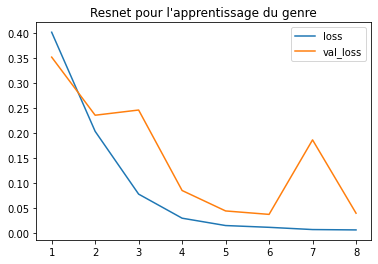

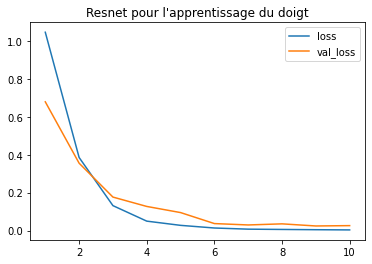

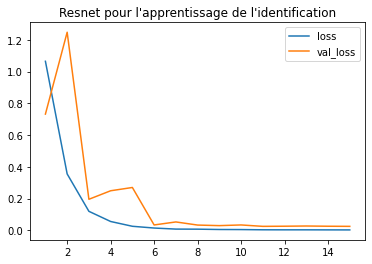

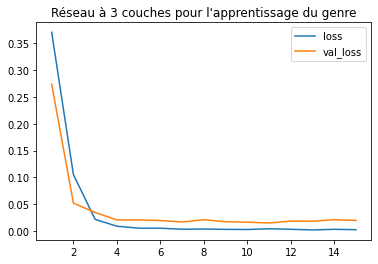

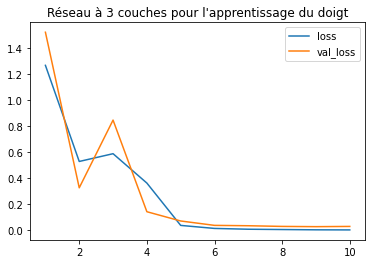

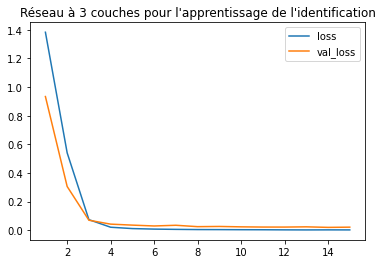

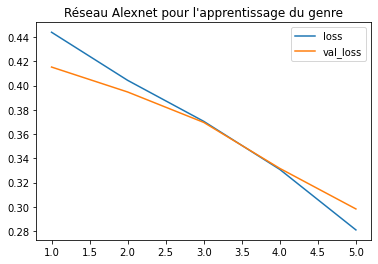

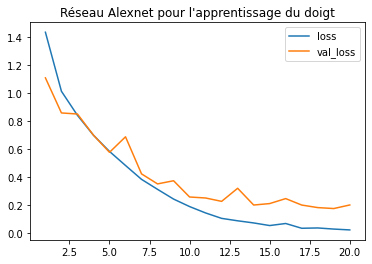

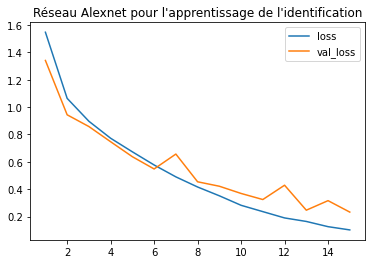

In [ ]:
logs_resnet_gender = pd.read_csv(os.path.join(save_path, 'log_resnet_gender.tsv'), sep='\t')
logs_resnet_finger = pd.read_csv(os.path.join(save_path, 'log_resnet_finger.tsv'), sep='\t')
logs_resnet_id = pd.read_csv(os.path.join(save_path, 'log_resnet_id.tsv'), sep='\t')
logs_reseau_gender = pd.read_csv(os.path.join(save_path, 'log_reseau_gender.tsv'), sep='\t')
logs_reseau_finger = pd.read_csv(os.path.join(save_path, 'log_reseau_finger.tsv'), sep='\t')
logs_reseau_id = pd.read_csv(os.path.join(save_path, 'log_reseau_id.tsv'), sep='\t')
logs_alexnet_gender = pd.read_csv(os.path.join(save_path, 'log_alexnet_gender.tsv'), sep='\t')
logs_alexnet_finger = pd.read_csv(os.path.join(save_path, 'log_alexnet_finger.tsv'), sep='\t')
logs_alexnet_id = pd.read_csv(os.path.join(save_path, 'log_alexnet_id.tsv'), sep='\t')
logs = pd.concat([logs_resnet_gender, logs_resnet_finger, logs_resnet_id, logs_reseau_gender, logs_reseau_finger, logs_reseau_id, logs_alexnet_gender, logs_alexnet_finger,logs_alexnet_id], axis=1)
display(logs)

metrics = ['loss', 'val_loss']
plt.plot(logs_resnet_gender['epoch'], logs_resnet_gender[metrics])
plt.legend(metrics)
plt.title("Resnet pour l'apprentissage du genre")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_resnet_finger['epoch'], logs_resnet_finger[metrics])
plt.legend(metrics)
plt.title("Resnet pour l'apprentissage du doigt")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_resnet_id['epoch'], logs_resnet_id[metrics])
plt.legend(metrics)
plt.title("Resnet pour l'apprentissage de l'identification")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_reseau_gender['epoch'], logs_reseau_gender[metrics])
plt.legend(metrics)
plt.title("Réseau à 3 couches pour l'apprentissage du genre")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_reseau_finger['epoch'], logs_reseau_finger[metrics])
plt.legend(metrics)
plt.title("Réseau à 3 couches pour l'apprentissage du doigt")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_reseau_id['epoch'], logs_reseau_id[metrics])
plt.legend(metrics)
plt.title("Réseau à 3 couches pour l'apprentissage de l'identification")
plt.show()


metrics = ['loss', 'val_loss']
plt.plot(logs_alexnet_gender['epoch'], logs_alexnet_gender[metrics])
plt.legend(metrics)
plt.title("Réseau Alexnet pour l'apprentissage du genre")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_alexnet_finger['epoch'], logs_alexnet_finger[metrics])
plt.legend(metrics)
plt.title("Réseau Alexnet pour l'apprentissage du doigt")
plt.show()

metrics = ['loss', 'val_loss']
plt.plot(logs_alexnet_id['epoch'], logs_alexnet_id[metrics])
plt.legend(metrics)
plt.title("Réseau Alexnet pour l'apprentissage de l'identification")
plt.show()

# Test

## Resnet

In [ ]:
# Affichage du score en test pour la classification du genre - RESNET
test_loss_resnet_gender, test_acc_resnet_gender = model_fit_resnet_gender.evaluate_generator(test_dataloader_gender)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss_resnet_gender, test_acc_resnet_gender))


Test steps: 86 9.96s test_loss: 1.346895 test_bin_acc: 77.078775                                
Test:
	Loss: 1.3468949813781985
	Accuracy: 77.07877462263268


In [ ]:
# Affichage du score en test pour la classification du doigt - RESNET
test_loss_resnet_finger, (test_acc_resnet_finger, test_f1_resenet_finger) = model_fit_resnet_finger.evaluate_generator(test_dataloader_finger)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_resnet_finger, test_acc_resnet_finger, test_f1_resenet_finger))

Test steps: 86 7.41s test_loss: 1.593023 test_acc: 67.067834 test_fscore_micro: 0.670678    
Test:
	Loss: 1.5930232117421257
	Accuracy: 67.0678336924658
	F1-score: 0.6706783175468445


In [ ]:
# Affichage du score en test pour la classification de l'identification - RESNET
test_loss_resnet_id, (test_acc_resnet_id, test_f1_resnet_id) = model_fit_resnet_id.evaluate_generator(test_dataloader_id)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_resnet_id, test_acc_resnet_id, test_f1_resnet_id))

Test steps: 86 7.26s test_loss: 1.545115 test_acc: 67.523705 test_fscore_micro: 0.675237    
Test:
	Loss: 1.5451150832604006
	Accuracy: 67.52370533014543
	F1-score: 0.6752370595932007


## Réseau 

In [ ]:
# Affichage du score en test pour la classification du genre - RÉSEAU
test_loss_reseau_gender, test_acc_reseau_gender = model_fit_reseau_gender.evaluate_generator(test_dataloader_gender)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss_reseau_gender, test_acc_reseau_gender))

Test steps: 86 4.94s test_loss: 1.389622 test_bin_acc: 75.838804                                
Test:
	Loss: 1.3896219697527508
	Accuracy: 75.83880381511129


In [ ]:
# Affichage du score en test pour la classification du doigt - RÉSEAU
test_loss_reseau_finger, (test_acc_reseau_finger, test_f1_reseau_finger) = model_fit_reseau_finger.evaluate_generator(test_dataloader_finger)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_reseau_finger, test_acc_reseau_finger, test_f1_reseau_finger))

Test steps: 86 4.97s test_loss: 1.462412 test_acc: 61.761488 test_fscore_micro: 0.617615    
Test:
	Loss: 1.462411550784761
	Accuracy: 61.76148800394294
	F1-score: 0.6176148653030396


In [ ]:
# Affichage du score en test pour la classification de l'identification - RÉSEAU
test_loss_reseau_id, (test_acc_reseau_id, test_f1_reseau_id) = model_fit_reseau_id.evaluate_generator(test_dataloader_id)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_reseau_id, test_acc_reseau_id, test_f1_reseau_id))

Test steps: 86 5.03s test_loss: 1.547031 test_acc: 62.144420 test_fscore_micro: 0.621444    
Test:
	Loss: 1.5470310883042746
	Accuracy: 62.14442012016135
	F1-score: 0.6214442253112793


## Alexnet

In [ ]:
# Affichage du score en test pour la classification du genre - ALEXNET
test_loss_alexnet_gender, test_acc_alexnet_gender = model_fit_alexnet_gender.evaluate_generator(RBG_test_dataloader_gender)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss_alexnet_gender, test_acc_alexnet_gender))

Test steps: 86 5.32s test_loss: 0.592410 test_bin_acc: 78.719912                                
Test:
	Loss: 0.592409739764789
	Accuracy: 78.71991246708286


In [ ]:
# Affichage du score en test pour la classification du doigt - ALEXNET
test_loss_alexnet_finger, (test_acc_alexnet_finger, test_f1) = model_fit_alexnet_finger.evaluate_generator(RBG_test_dataloader_finger)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_alexnet_finger, test_acc_alexnet_finger, test_f1))

Test steps: 86 5.31s test_loss: 1.933931 test_acc: 69.839533 test_fscore_micro: 0.698395    
Test:
	Loss: 1.933930598759112
	Accuracy: 69.83953319023684
	F1-score: 0.698395311832428


In [ ]:
# Affichage du score en test pour la classification de l'identification - ALEXNET
test_loss_alexnet_id, (test_acc_alexnet_id, test_f1) = model_fit_alexnet_id.evaluate_generator(RBG_test_dataloader_id)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss_alexnet_id, test_acc_alexnet_id, test_f1))

Test steps: 86 5.36s test_loss: 1.492227 test_acc: 69.766594 test_fscore_micro: 0.697666    
Test:
	Loss: 1.4922270498338361
	Accuracy: 69.7665937105119
	F1-score: 0.6976659297943115


# Récapitulation des résultats

In [ ]:
resultats = [('Resnet','genre',logs_resnet_gender['time'][7],logs_resnet_gender['loss'][7],logs_resnet_gender['bin_acc'][7],logs_resnet_gender['val_loss'][7],logs_resnet_gender['val_bin_acc'][7],test_loss_resnet_gender,test_acc_resnet_gender),
             ('Resnet','doigt',logs_resnet_finger['time'][9],logs_resnet_finger['loss'][9],logs_resnet_finger['acc'][9],logs_resnet_finger['val_loss'][9],logs_resnet_finger['val_acc'][9],test_loss_resnet_finger,test_acc_resnet_finger),
             ('Resnet','identité',logs_resnet_id['time'][14],logs_resnet_id['loss'][14],logs_resnet_id['acc'][14],logs_resnet_id['val_loss'][14],logs_resnet_id['val_acc'][14],test_loss_resnet_id,test_acc_resnet_id),

             ('Réseau','genre',logs_reseau_gender['time'][14],logs_reseau_gender['loss'][14],logs_reseau_gender['bin_acc'][14],logs_reseau_gender['val_loss'][14],logs_reseau_gender['val_bin_acc'][7],test_loss_reseau_gender,test_acc_reseau_gender),
             ('Réseau','doigt',logs_reseau_finger['time'][9],logs_reseau_finger['loss'][9],logs_reseau_finger['acc'][9],logs_reseau_finger['val_loss'][9],logs_reseau_finger['val_acc'][9],test_loss_reseau_finger,test_acc_reseau_finger),
             ('Réseau','identité',logs_reseau_id['time'][14],logs_reseau_id['loss'][14],logs_reseau_id['acc'][14],logs_reseau_id['val_loss'][14],logs_reseau_id['val_acc'][14],test_loss_reseau_id,test_acc_reseau_id),

             ('AlexNet','genre',logs_alexnet_gender['time'][4],logs_alexnet_gender['loss'][4],logs_alexnet_gender['bin_acc'][4],logs_alexnet_gender['val_loss'][4],logs_alexnet_gender['val_bin_acc'][4],test_loss_alexnet_gender,test_acc_alexnet_gender),
             ('AlexNet','doigt',logs_alexnet_finger['time'][19],logs_alexnet_finger['loss'][19],logs_alexnet_finger['acc'][19],logs_alexnet_finger['val_loss'][19],logs_alexnet_finger['val_acc'][7],test_loss_alexnet_finger,test_acc_alexnet_finger),
             ('AlexNet','identité',logs_alexnet_id['time'][14],logs_alexnet_id['loss'][14],logs_alexnet_id['acc'][14],logs_alexnet_id['val_loss'][14],logs_alexnet_id['val_acc'][14],test_loss_alexnet_id,test_acc_alexnet_id)
]
col = ['Nom du réseau','Type de classification','training_time/epoch (sec)', 'Train loss', 'Train accuracy', 'Validation loss', 'Validation accuracy','Test loss','Test accuracy' ]

df = pd.DataFrame(data=resultats, columns = col)
display(df.style.hide_index())

Nom du réseau,Type de classification,training_time/epoch (sec),Train loss,Train accuracy,Validation loss,Validation accuracy,Test loss,Test accuracy
Resnet,genre,100.359818,0.005988,99.839311,0.039494,98.821639,1.346895,77.078775
Resnet,doigt,99.947149,0.003517,99.954089,0.026135,99.209963,1.593023,67.067834
Resnet,identité,99.097155,0.002019,99.974175,0.024456,99.283610,1.545115,67.523705
Réseau,genre,62.967115,0.002629,99.968436,0.019914,99.524638,1.389622,75.838804
Réseau,doigt,60.536090,0.004331,99.959828,0.031081,99.323781,1.462412,61.761488
Réseau,identité,61.838865,0.002025,99.988522,0.021217,99.491162,1.547031,62.144420
AlexNet,genre,67.276524,0.280879,88.200861,0.298189,87.727638,0.592410,78.719912
AlexNet,doigt,65.902028,0.022712,99.291248,0.200686,87.680771,1.933931,69.839533
AlexNet,identité,67.216347,0.102597,96.461980,0.232801,92.889663,1.492227,69.766594
